In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def best_arm_finder(rewards,counts,trial,n_arms=12,c=1):
    """This function find best arm for UCB
    Args:
      rewards: list of rewards, where the reward for each arm is the average reward after trial-1
      counts: List of Number of time a arm is played after trial-1
      trial: current trial
      n_arms: Number of arms in UCB
      c:UCB constant
    Returns:
      a Best arm after trial round
    """
    best_arm = -1
    best_ucb = -float('inf')
    for arm in range(n_arms):
        ucb_val = rewards[arm] / counts[arm] + c*np.sqrt(np.log(trial+1)/counts[arm])
        if ucb_val > best_ucb:
          best_arm = arm
          best_ucb = ucb_val
    return best_arm

In [3]:
def reward_generator(sample,thresh,arm,lembda,o):
    """This Function find reward,cost,prediction for a sample

    Args:
        sample (array): list of confidence for each exit
        thresh (float): Threshhold 
        arm (integer): optimal exit at particular trial
        lembda (float): battery deplication rate
        o (float): offloading cost

    Returns:
        reward: reward of particular trial  
    """
    if arm<11:
        if max(sample[arm])>=thresh:
            reward=max(sample[arm])-lembda*((arm+1))
        else:
            reward=max(sample[11])-o-lembda*((arm+1))
    else:
        reward=max(sample[arm])-lembda*((arm+1))
    return reward

In [8]:
def UCB(df,best_arm_pre,threshhold,lembda,o,n_arms=12,n_epoch=5):
    """
    This function implements the Upper Confidence Bound (UCB) algorithm.

    Args:
        df: dataframe
        best_arm_pre: best arm which got by implementing UCB
        threshhold: threshhold value
        lembda :    battery deplication rate
        O:          Ofloading cost
        n_arms:     The number of arms.
        n_epoch:    The number of epoch.

    Returns:
regret_with_side_information: regret of our model
regret_random: regret whem we random arm to exit
regret_final: when we choose final layer as optimum layer
        """
    rewards_list_final=[]
    regret_with_side_information=[]
    regret_random=[]
    regret_final=[]
    for _ in range(n_epoch):
        data=df.sample(frac=1).to_numpy()
        x=data[:,:-1]
        rewards_list=[]
        count_list=[0 for i in range(n_arms)]
        regret_with_side_information1=[]
        regret_random1=[]
        regret_final1=[]
        random_arm=np.random.choice(range(12))
        #initialise reward
        for i in range(n_arms):
            reward=reward_generator(x[i],threshhold,i,lembda,o)
            rewards_list.append(reward)
            count_list[i]+=1
        for trial in range(df.shape[0]):
            best_arm=best_arm_finder(rewards_list,count_list,trial,n_arms=12,c=1)
            for pr_arm in range(best_arm+1):
                reward=reward_generator(x[trial],threshhold,pr_arm,lembda,o)
                rewards_list[pr_arm]+=reward
                count_list[pr_arm]+=1
            reward_best=reward_generator(x[trial],threshhold,best_arm_pre,lembda,o)
            regret_with_side_information1.append(reward_best-reward)
            regret_random1.append(reward_best-reward_generator(x[trial],threshhold,random_arm,lembda,o))
            regret_final1.append(reward_best-reward_generator(x[trial],threshhold,11,lembda,o))
        rewards_list_final.append(rewards_list)
        regret_with_side_information.append(regret_with_side_information1)
        regret_random.append(regret_random1)
        regret_final.append(regret_final1)
    return regret_with_side_information,regret_random,regret_final

In [9]:
def UCB_without_using_side_info(df,best_arm_pre,threshhold,lembda,o,n_arms=12,n_epoch=5):
    """
    This function implements the Upper Confidence Bound (UCB) algorithm.

    Args:
        df: dataframe
        threshhold: threshhold value
        lembda :    battery deplication rate
        O:          Ofloading cost
        n_arms:     The number of arms.
        n_epoch:    The number of epoch.
        c:          costant of ucb

    Returns:
    regret: regret of our model without using side information
        """
    regret=[]
    for _ in range(n_epoch):
        data=df.sample(frac=1).to_numpy()
        x=data[:,:-1]
        y=data[:,-1]
        rewards_list=[]
        count_list=[0 for i in range(n_arms)]
        regret1=[]
        #initialise reward
        for i in range(n_arms):
            reward=reward_generator(x[i],threshhold,i,lembda,o)
            rewards_list.append(reward)
            count_list[i]+=1
        for trial in range(df.shape[0]):
            best_arm=best_arm_finder(rewards_list,count_list,trial,n_arms=12,c=1)
            reward=reward_generator(x[trial],threshhold,best_arm,lembda,o)
            rewards_list[best_arm]+=reward
            count_list[best_arm]+=1
            reward_best=reward_generator(x[trial],threshhold,best_arm_pre,lembda,o)
            regret1.append(reward_best-reward)
        regret.append(regret1)
    return regret

In [10]:
result={}
df_results_dict=pd.read_pickle('/home/divya/updated_code/Dataset/confidence_label_dict.pkl')
dataset_name=['imdb','scitail','yelp','qqp','snli']
threshhold = {'imdb':0.7,'scitail':0.85,'yelp':0.7,'qqp':0.75,'snli':0.75}
best_arm_dict = {'imdb':2,'scitail':0,'yelp':2,'qqp':3,'snli':2}
best_arm_dict_without = {'imdb':2,'scitail':0,'yelp':2,'qqp':3,'snli':2}
lembda=1/10
offload_cost=0.5
i=0
for dataset in dataset_name:
    df=df_results_dict[dataset]
    reward_with_side_information,reward_random,reward_final=UCB(df,best_arm_dict[dataset],threshhold[dataset],lembda,offload_cost,n_arms=12,n_epoch=5)
    reward_without_using_side_info=UCB_without_using_side_info(df,best_arm_dict[dataset],threshhold[dataset],lembda,offload_cost,n_arms=12,n_epoch=5)
    result[dataset]={'with side info':reward_with_side_information,'random':reward_random,'final':reward_final,'without side_info':reward_without_using_side_info}

In [11]:
import scipy.stats as st
def ci_compute(results_list):
    """generate lower bound upper bound and mean of cummulative regret

    Args:
        results_list : cummulative regret

    Returns:
        a tupple of lower bound upper bound and mean
    """
    ci_lb=[]
    ci_up=[]
    mean_list=[]
    for i in range(results_list.shape[1]):
        data=results_list[:,i]
        a,b=st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
        ci_lb.append(a) 
        ci_up.append(b)
        mean_list.append(np.mean(data))
    return (ci_lb,ci_up,mean_list)

In [12]:
def cumsum(data):
    """ generate cummulative regret by taking regret of sample

    Args:
        data : list of regret for each epoch

    Returns:
        cummulative regret for each epoch
    """
    dataset=[]
    for i in data:
        dataset.append(np.cumsum(np.array(i)))
    return dataset

In [13]:
def regret_plot_data(ax_name,result,dataset_name,threshhold):
    ci_list=[ci_compute(np.array(cumsum(result[dataset_name.lower()]['without side_info']))[:,:2000]),ci_compute(np.array(cumsum(result[dataset_name.lower()]['with side info']))[:,:2000]),ci_compute(np.array(cumsum(result[dataset_name.lower()]['random']))[:,:2000]),ci_compute(np.array(cumsum(result[dataset_name.lower()]['final']))[:,:2000])]
    reward_without_using_side_info=ci_list[0][2]
    reward_last_arm=ci_list[3][2]
    reward_using_side_info=ci_list[1][2]
    reward_random_arm=ci_list[2][2]
    ax_name.plot(range(len(reward_without_using_side_info)),reward_without_using_side_info,color='g',label='AMOVE',linestyle='-')
    ax_name.plot(range(len(reward_using_side_info)),reward_using_side_info,color='r',label='AMOVE-S')
    ax_name.plot(range(len(reward_random_arm)),reward_random_arm,color='b',label='Random selection',linestyle='--')
    ax_name.plot(range(len(reward_last_arm)),reward_last_arm,color='midnightblue',label='Final exit',linestyle=':')
    ax_name.fill_between(range(len(reward_without_using_side_info)), ci_list[0][0],ci_list[0][1], color='g', alpha=0.2)
    ax_name.fill_between(range(len(reward_without_using_side_info)), ci_list[1][0], ci_list[1][1], color='r', alpha=0.2)
    ax_name.fill_between(range(len(reward_without_using_side_info)), ci_list[3][0], ci_list[3][1], color='midnightblue', alpha=0.2)
    ax_name.tick_params(axis='x', labelsize=16)
    ax_name.tick_params(axis='y', labelsize=16)
    if dataset_name=='IMDb':
        ax_name.set_ylabel('cummulative Regret',fontsize=18)
    ax_name.set_xlabel('Time horizon',fontsize=18)
    ax_name.set_title(f'{dataset_name} with {threshhold} threshhold ',fontsize=18)
    ax_name.legend(fontsize=18)

/tmp/ipykernel_1474777/2059741879.py:16: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  a,b=st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
/home/divya/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/divya/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


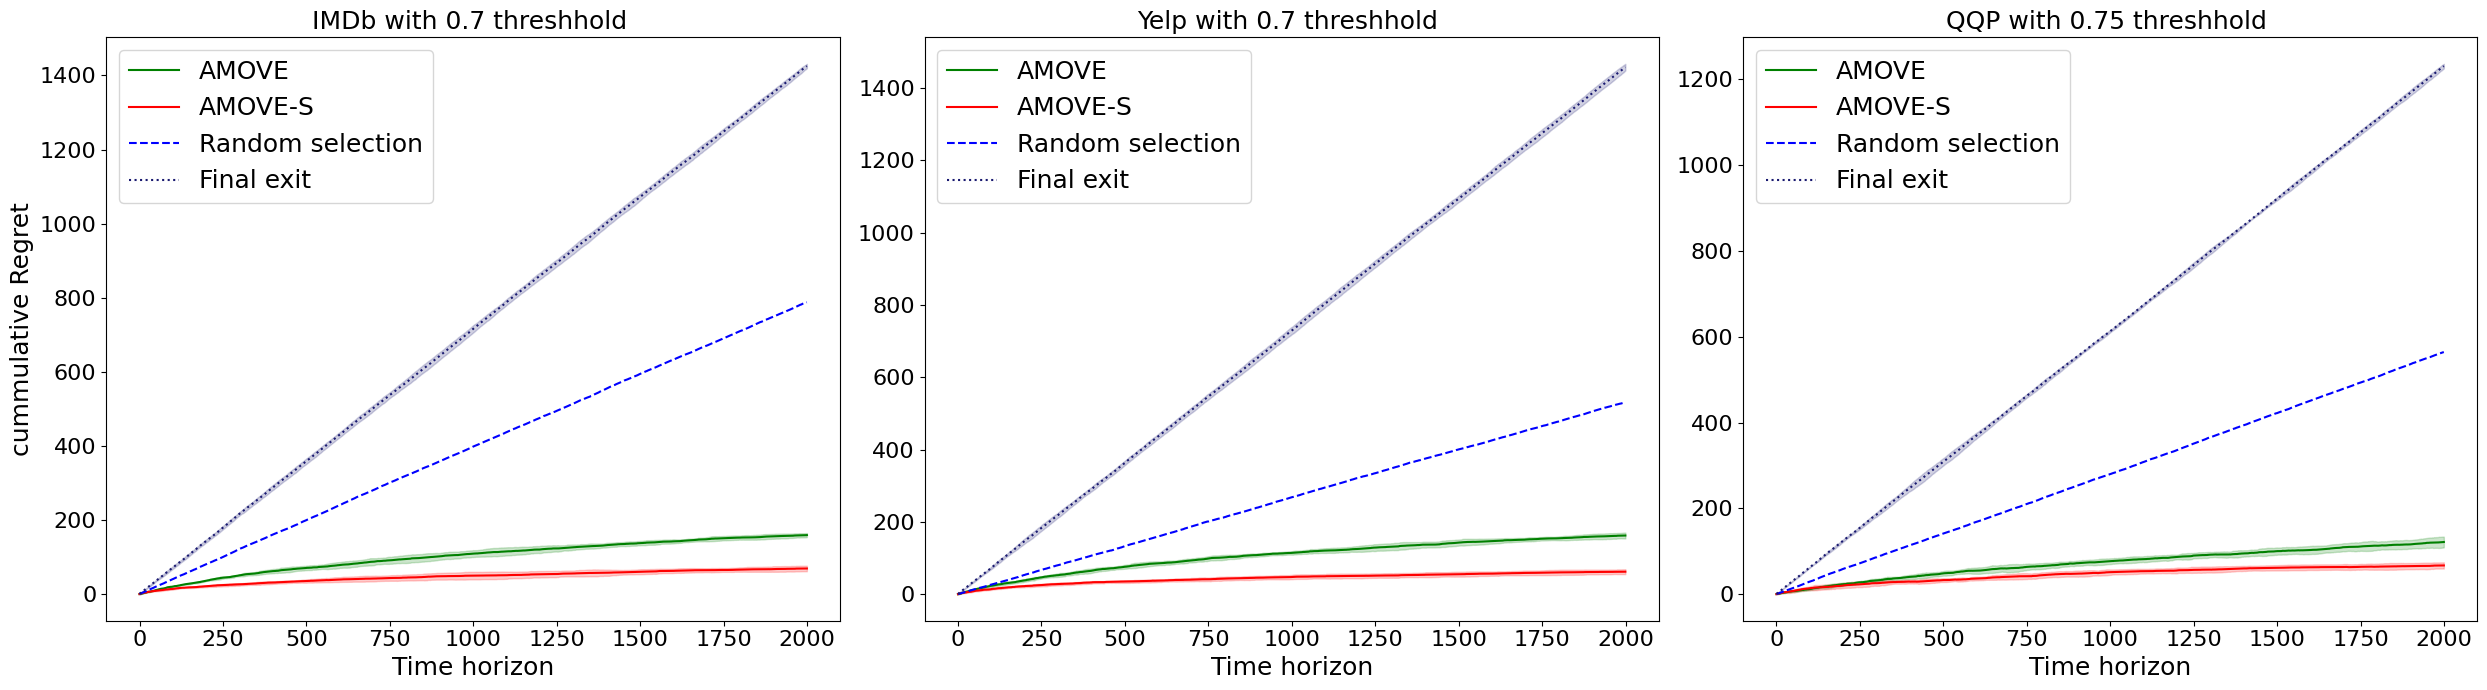

In [14]:
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3,figsize=(25, 7))
l=[ax1, ax2,ax3]
# df_results_dict=pd.read_pickle('/home/divya/vivek_sohan_upd/Experiments/pickle_file/df_results_dict.pkl')
dataset_name=['IMDb','Yelp','QQP']
threshhold = {'IMDb':0.7,'Yelp':0.7,'QQP':0.75}
best_arm_dict = {'IMDb':2,'Yelp':2,'QQP':3}
best_arm_dict_without = {'IMDb':2,'Yelp':2,'QQP':3}
for i  in range(len(l)):
    regret_plot_data(l[i],result,dataset_name[i],threshhold[dataset_name[i]]) 
fig.tight_layout()
fig.savefig("/home/divya/updated_code/regret_plots/regret_plot.pdf", format="pdf", bbox_inches="tight")
fig.show()  

/tmp/ipykernel_1474777/2059741879.py:16: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  a,b=st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
/home/divya/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/divya/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


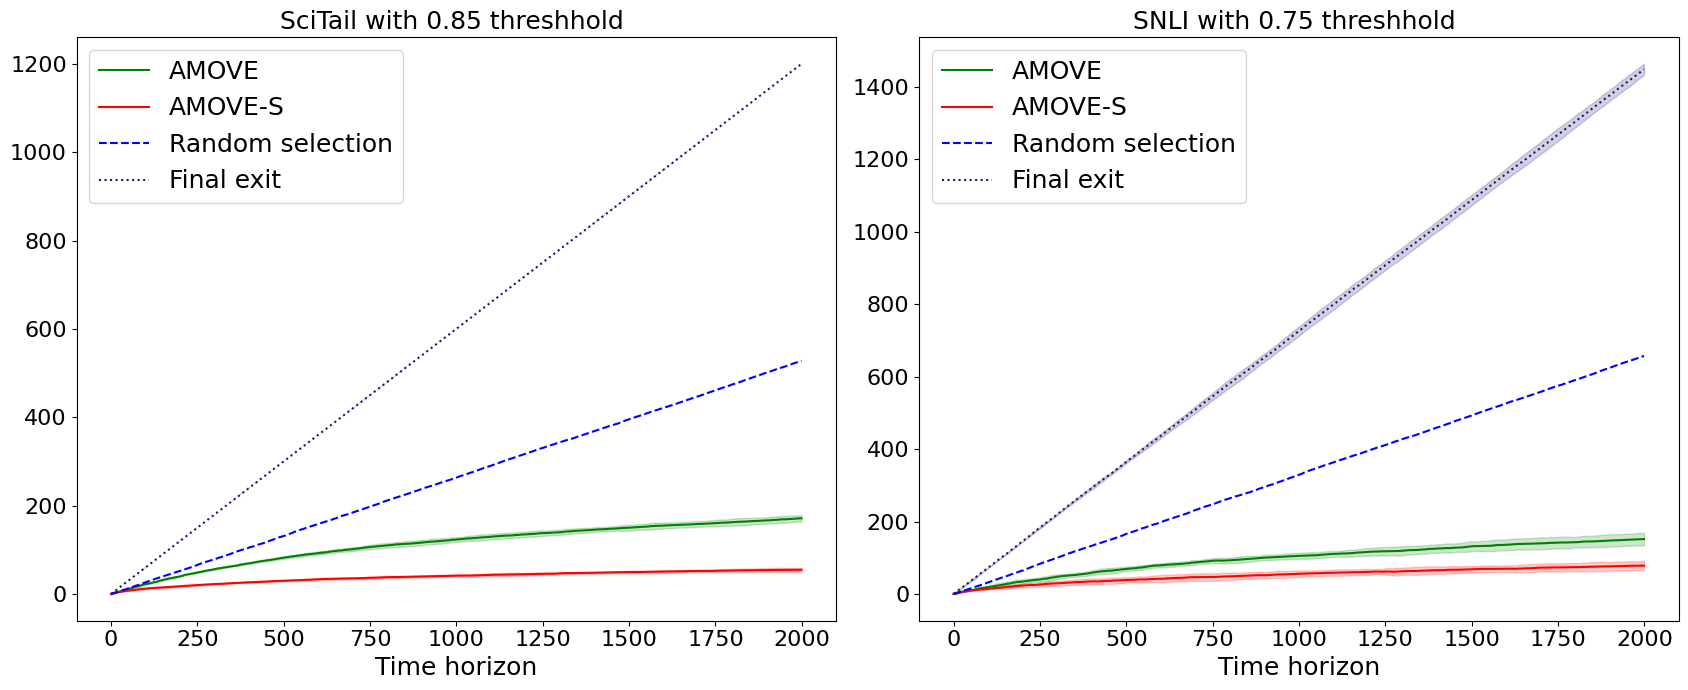

In [15]:
fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(17, 7))
l=[ax1, ax2]
dataset_name=['SciTail','SNLI']
threshhold = {'SciTail':0.85,'SNLI':0.75}
best_arm_dict = {'SciTail':0,'SNLI':2}
best_arm_dict_without = {'SciTail':0,'SNLI':2}
for i  in range(len(l)):
    regret_plot_data(l[i],result,dataset_name[i],threshhold[dataset_name[i]])
    
  
fig.tight_layout()
fig.savefig("/home/divya/updated_code/regret_plots/regret_plot1.pdf", format="pdf", bbox_inches="tight")
fig.show()